### Import packages:

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from generator import fitness, generate

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [ ]:
# If running on Colab, we need to specify the path of this notebook
import sys
if "google.colab" in sys.modules:
  # Set this to the directory of this file in Google Drive
  notebook_path = '/content/drive/MyDrive/CISC 455/light_weighted_cpu' 
  sys.path.append(notebook_path)
  from google.colab import files
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
# !pip install chainer==7.2.0

### Load data:

In [17]:
file_path = "."
model_dir = "saved_models"

if "google.colab" in sys.modules:
  file_path = notebook_path

In [3]:
latent_vecs = pd.read_csv(f"{file_path}/encoded_training.csv")

### K-means clustering:
*   Inside the latent space, there might contain clusters such that these levels are semantically similar to each other.
*   Therefore, we would like to use a K-means clustering to capture that.

<br>

*   An issue can be: how to choose the number of clusters?
    *   We select that based on a metric called Silhouette value.

In [25]:
np.random.seed(40)

sil_val = []
kmax = 20

# k start from 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(latent_vecs)
  labels = kmeans.labels_
  sil_val.append(silhouette_score(latent_vecs, labels, metric = 'euclidean'))

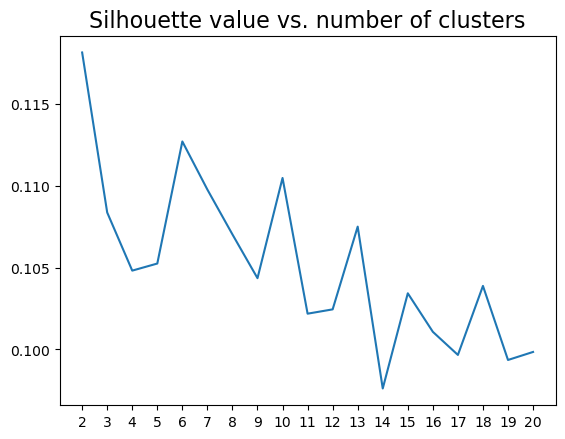

In [26]:
plt.plot(range(2,kmax+1), sil_val)
plt.xticks(range(2,kmax+1))
plt.title("Silhouette value vs. number of clusters", fontsize = 16)
plt.show()

*   It is true that no strong clustering behavior is observed.
*   For diversity, $k=6$ is a local maximum so can be a good choice.

In [8]:
k = 6
kmeans = KMeans(n_clusters=k)
kmeans.fit(latent_vecs)
centroids = kmeans.cluster_centers_

In [9]:
centroids.shape

(6, 60)

*   Retrieve the clusters and their diameters.

In [10]:
max_dist = [0 for _ in range(k)]
clusters = [[] for _ in range(k)]
latent_vecs_array = latent_vecs.to_numpy()
for i in range(latent_vecs.shape[0]):
    dist_list = [np.linalg.norm(centroids[j] - latent_vecs_array[i]) for j in range(k)]
    assign_cent = np.argmin(dist_list)
    clusters[assign_cent].append(i)
    max_dist[assign_cent] = max(dist_list[assign_cent], max_dist[assign_cent])

### Visualize clusters:
*   Use t-SNE for visualization.

In [28]:
tsne = TSNE(init="pca", learning_rate="auto", random_state=40)
latent_vecs_2D = tsne.fit_transform(latent_vecs_array)

d:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


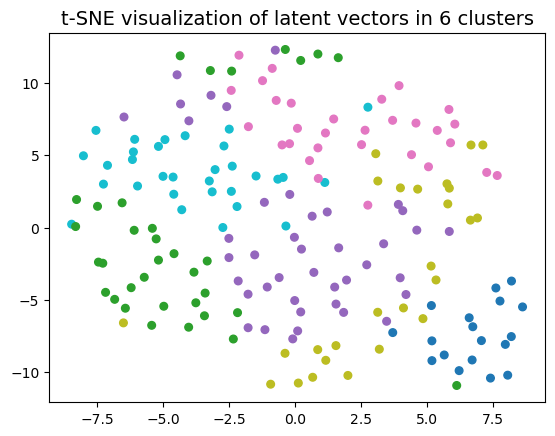

In [36]:
cluster_list = []
for i in range(latent_vecs.shape[0]):
    for j in range(k):
        if i in clusters[j]:
            cluster_list.append(j)
            break

plt.scatter(latent_vecs_2D[:, 0], latent_vecs_2D[:, 1], c=cluster_list, s=30, cmap="tab10")
plt.title("t-SNE visualization of latent vectors in 6 clusters", fontsize = 14)
plt.show()

### Generate levels and evaluate:
*   We use centroids as $\mu$
*   Use the distance for each cluster as $2\sigma$:
    *   So that we assume all individuals have 95% chance to be generated within each cluster.

In [19]:
latent_vec_list = []
    
for i in range(k):
    # Randomly create some mean and variance
    mean = centroids[1].reshape(-1,1).T
    std = max_dist[i] / 2

    # Multi-variate normal
    for i in range(5):
        latent_vec = np.random.normal(mean, std, size=mean.shape)
        latent_vec_list.append(latent_vec)

In [20]:
fitness_list = fitness(latent_vecs = latent_vec_list, 
                       file_path = file_path, 
                       model_dir = model_dir)



for i in range(len(fitness_list)):
    print("Vector %d: pig count: %d, tnt count: %d, material types: %d, object types: %d, object count: %d" 
          % (i, fitness_list[i][0], fitness_list[i][1], fitness_list[i][2], fitness_list[i][3], fitness_list[i][4]))

100%|██████████| 30/30 [00:06<00:00,  4.56it/s]

Vector 0: pig count: 5, tnt count: 0, material types: 4, object types: 10, object count: 29
Vector 1: pig count: 1, tnt count: 0, material types: 4, object types: 6, object count: 18
Vector 2: pig count: 4, tnt count: 0, material types: 4, object types: 7, object count: 62
Vector 3: pig count: 1, tnt count: 0, material types: 4, object types: 8, object count: 19
Vector 4: pig count: 4, tnt count: 0, material types: 4, object types: 6, object count: 40
Vector 5: pig count: 3, tnt count: 0, material types: 4, object types: 4, object count: 10
Vector 6: pig count: 1, tnt count: 0, material types: 4, object types: 7, object count: 42
Vector 7: pig count: 1, tnt count: 1, material types: 4, object types: 8, object count: 31
Vector 8: pig count: 1, tnt count: 0, material types: 4, object types: 9, object count: 114
Vector 9: pig count: 4, tnt count: 0, material types: 4, object types: 7, object count: 73
Vector 10: pig count: 2, tnt count: 0, material types: 4, object types: 10, object count